<center> <h1> Lecture 8: Generative Modeling and Generative Adversarial Networks </h1> </center>
<center> Krishna Pillutla, Lang Liu, Zaid Harchaoui </center>
    <center> Data 598 (Winter 2022), University of Washington </center>

In this lecture, we will talk about deep generative models briefly and about generative adversarial networks (GANs) in particular. 
We will also utilize some additional features of PyTorch such as training on GPUs. 

The demo is based on [the D2L book](https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html).

See [this NYT article](https://www.nytimes.com/interactive/2020/11/21/science/artificial-intelligence-fake-people-faces.html) for some beautiful illustrations of the impressive capabilities of modern generative models.

# Generative Modeling

Consider an unknown data distribution $P$, for instance over images, text, or audio. We wish to find a distribution $Q \approx P$ such that it is easy to generate synthetic samples from $Q$.

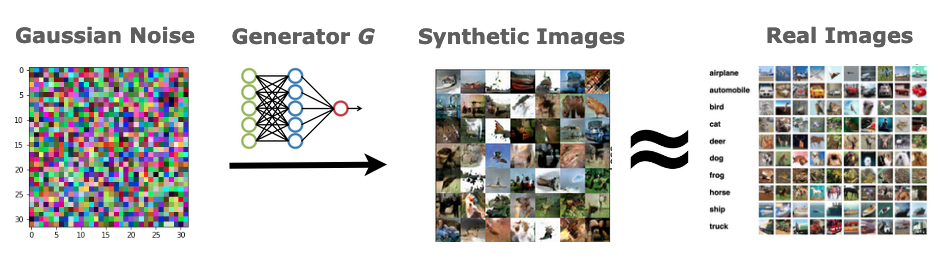

The general recipe of a generative model is to approximate it with a two-step procedure:
- sample $z \sim R$ from some simple distribution $R$ such as a Gaussian, and, 
- transform $z$ to $G(z)$ using a function $G(\cdot)$.


The distribution of $G(Z)$ for $Z \sim R$ is called the _pushforward distribution_ and is denoted as $G_\sharp R$. 

**Goal of generative modeling**: Find a map $G(\cdot)$ such that the distribution of $G(Z)$ for $Z \sim R$ is approximately equal to the data distribution $P$.

We parameterize the pushforward map $G(\cdot)$ using an expressive function class, such as a neural network. 

# Part 1: Practical Generative Models

We will experiment with state-of-the-art generative models for text. We will use an autoregressive transformer language model called GPT-2. 

**Trigger Warning**: The model could generate offensive text. Use at your own risk. 

In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Download the pre-trained model + tokenizer 
model_name = 'gpt2'   # ~500 MB in size
# model_name = "gpt2-large"  # For better results, ~2 GB in size

tokenizer = GPT2Tokenizer.from_pretrained(model_name) # to tokenize the text
model = GPT2LMHeadModel.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)  # PyTorch module

In [2]:
prompt = "Adele’s third album, 25, sold 5m copies in the US after it went on sale in November."

encoded_input = tokenizer.encode(prompt, return_tensors='pt')

generated_tokens = model.generate(encoded_input, do_sample=True, max_length=200, top_k=50)

generated_text = tokenizer.decode(generated_tokens[0])

print(generated_text)

Adele’s third album, 25, sold 5m copies in the US after it went on sale in November. The band's fifth album, 30. It also included a new track titled "Till the River Finishes".

Till the River Finishes is the second single in the band's six-piece "Till the World Finishes" (released by Styx Records in 1995).

"A world premiere of The Told Me My Girl"

"For me…this can be my greatest album… I have never known something like it. For me it's not that hard because it was a massive success and a huge moment in my life. Being the son of a teacher who is the only single father in the world can really make things really amazing for a mother and a kid especially and I want to do everything for my daughter and tell her all. It's very much about her, because she's the mother of her child. And I


The `top_k` argument determines how many candidate next tokens to sample from. 

### Exercise
Vary the `top_k` argument from 1 (choose the single most likely next token) 
to 5 to 50 to 500 and then 50000 (use all available tokens, you can also pass `top_k=0` for this). 

What do you observe in the quality of the generated text? 
- Under what settings does the model generate highly repetitive text? 
- When does the model produce text that is not meaningless? 
- When is the text reasonable?

In [3]:
prompt = "Adele’s third album, 25, sold 5m copies in the US after it went on sale in November."

encoded_input = tokenizer.encode(prompt, return_tensors='pt')

for k in [1, 5, 50, 500, 50000]:
    generated_tokens = model.generate(encoded_input, do_sample=True, max_length=200, top_k=k)

    generated_text = tokenizer.decode(generated_tokens[0])

    print(f'\n\nK={k}')
    print(generated_text)



K=1
Adele’s third album, 25, sold 5m copies in the US after it went on sale in November.

The album was released on the same day as the UK's biggest single, "I'm Not A Man".

The album was also released on the same day as the UK's biggest single, "I'm Not A Man".

The album was released on the same day as the UK's biggest single, "I'm Not A Man".

The album was released on the same day as the UK's biggest single, "I'm Not A Man".

The album was released on the same day as the UK's biggest single, "I'm Not A Man".

The album was released on the same day as the UK's biggest single, "I'm Not A Man".

The album was released on the same day as the UK's biggest single, "I'm Not A Man".

The album was released


K=5
Adele’s third album, 25, sold 5m copies in the US after it went on sale in November.

The album, which is based on the bestselling novel of the same name by John Updike, was released by the same label.<|endoftext|>


K=50
Adele’s third album, 25, sold 5m copies in the US after i

# Part 2: Evaluating Generative Models

A naïve way to evaluate generative models is to look at each of the generated samples and quantify its quality.
However, this individual-level approach is (a) too costly, and, (b)  cannot quantify the diversity of the data.

A more realistic approach is to compare generative models with real data on a distribution level.
To be more concrete, let $P$ be the real data distribution and $Q$ be the distribution of some generative model.
The "closer" $Q$ is to $P$, the better the generative model is.


## The Quality-Variety Trade-off

When evaluating generative models, it is common to have two failure cases: (1) high quality but low variety; (2) low quality but high variety.

<div>
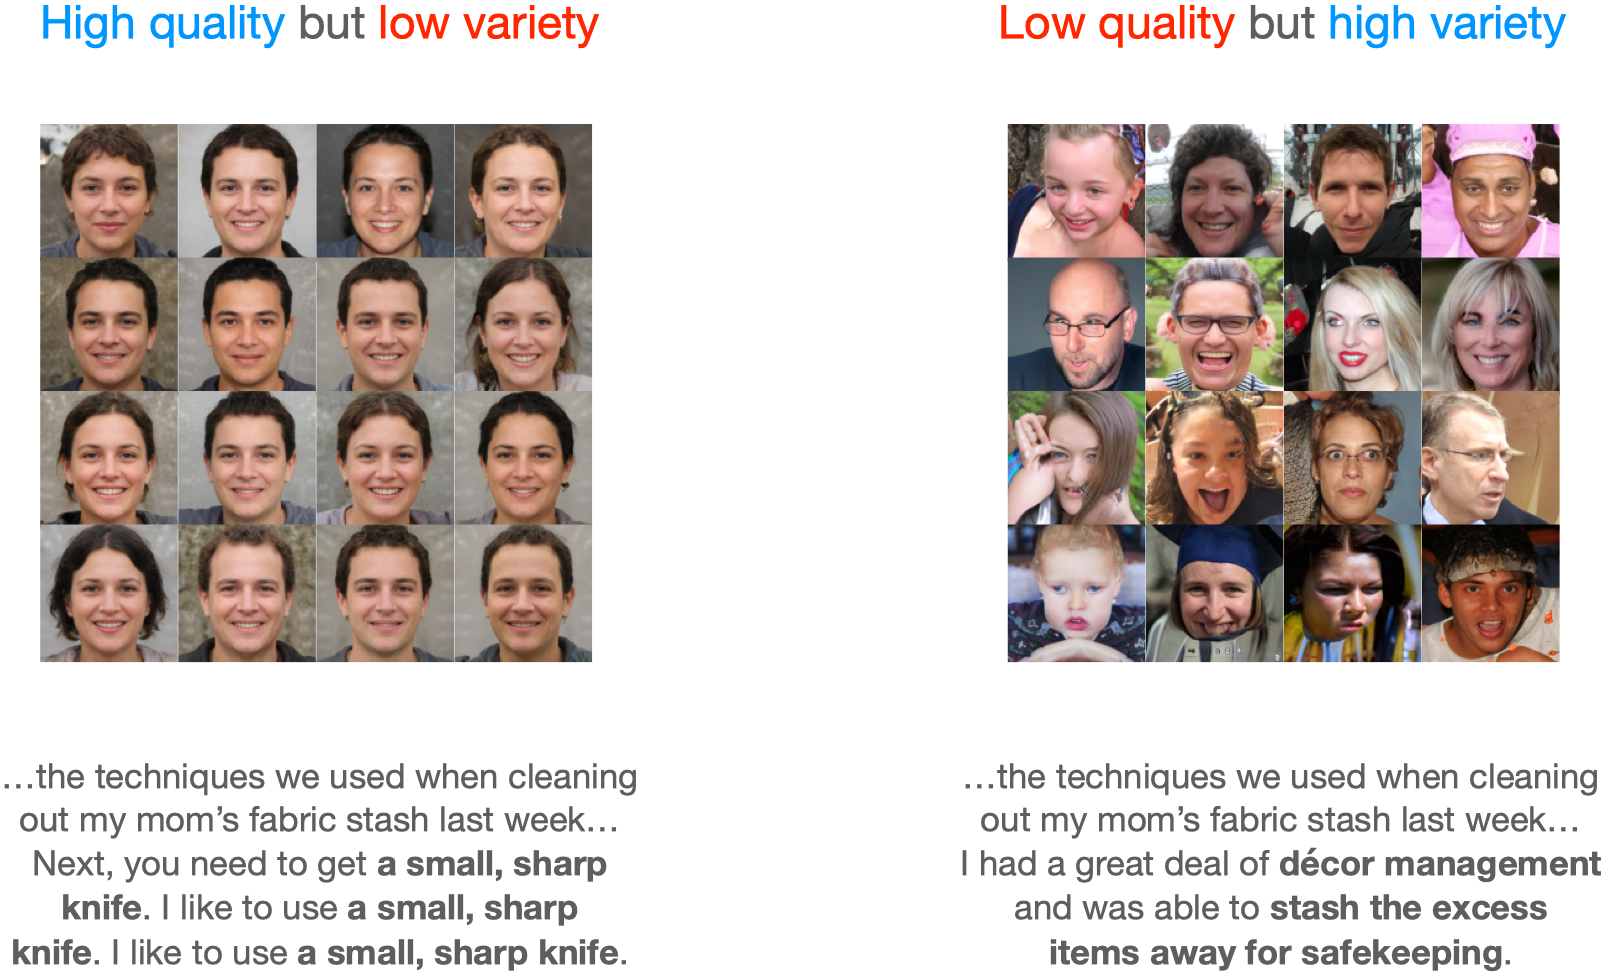
</div>


## Two Types of Errors

To describe the two failure cases, we introduce the notion of two types of errors -- (1) type I errors: samples that are highly likely to be generated by the model but less likely to exist in reality; (2) type II errors: samples that are highly likely to exist in reality but less likely to be generated by the model.
They can be quantified by the Kullback-Leibler (KL) divergences:
$$
\text{KL}(\color{red}{Q} \Vert \color{blue}{P}) := \int \log{\left( \frac{\color{red}{q(x)}}{\color{blue}{p(x)}} \right)} \color{red}{q(x)} dx \quad \text{and} \quad \text{KL}(\color{blue}{P} \Vert \color{red}{Q}) := \int \log{\left( \frac{\color{blue}{p(x)}}{\color{red}{q(x)}} \right)} \color{blue}{p(x)} dx
$$

<div>
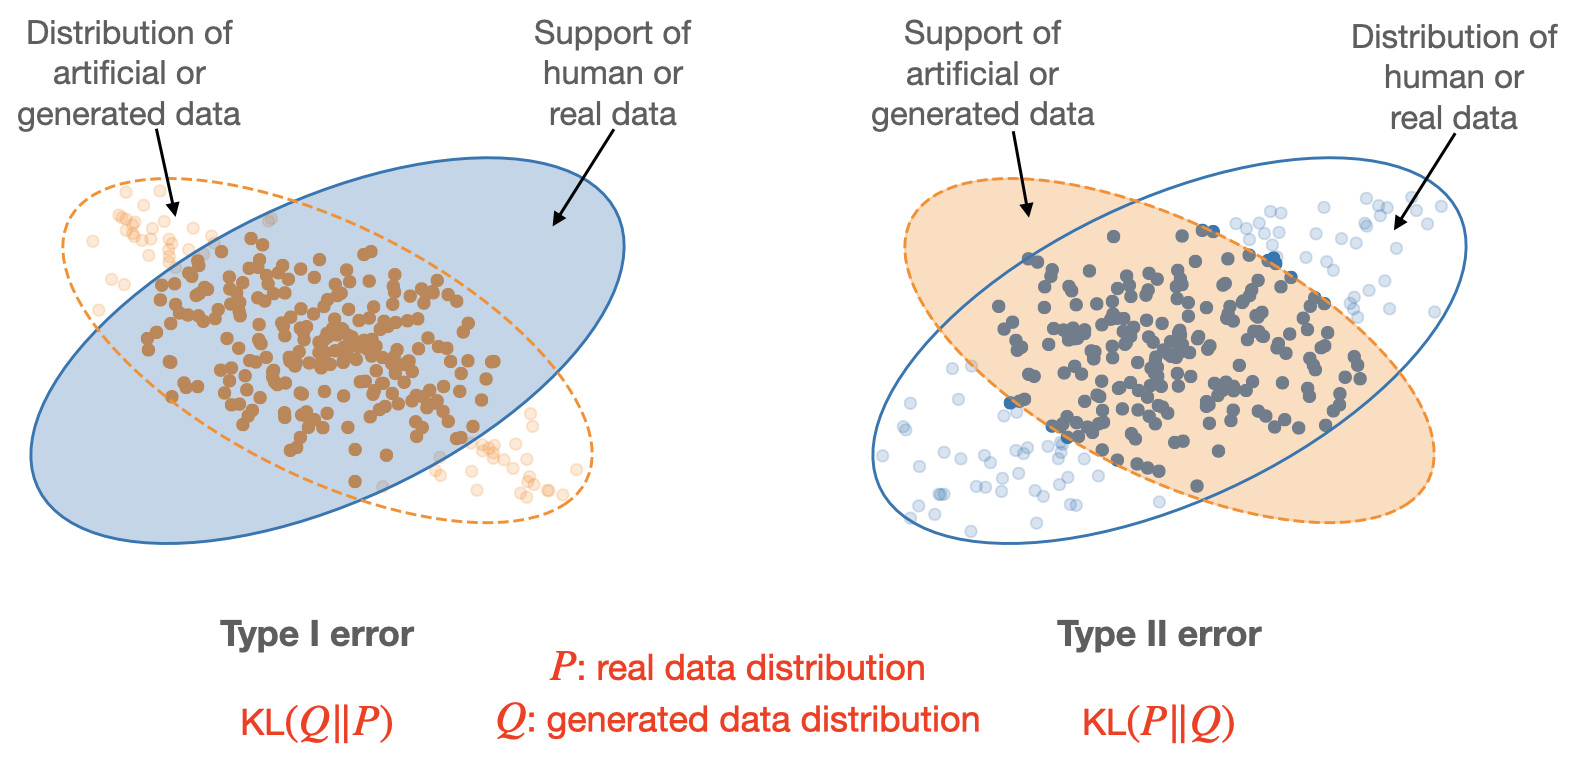
</div>


## Illustration of Two Types of Errors

Consider two distributions $P = 0.4 \mathcal{N}(-2.5, 1) + 0.6 \mathcal{N}(2.5, 1)$ and $Q = \mathcal{N}(\mu, 1.5)$.
Let us plot the two distributions and the two types of errors as we vary the mean $\mu$.

Please install the package `plotly` via `pip install plotly` before proceeding.

In [4]:
import numpy as np
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from scipy.stats import norm

In [5]:
# density of p
x = np.linspace(-10, 10, 200)
loc, scale = 2.5, 1.0
prob = 0.6
def pdensity(x):
    return (1 - prob)*norm.pdf(x, loc=-loc, scale=scale) + prob*norm.pdf(
    x, loc=loc, scale=scale)
px = pdensity(x)

# density of q
qscale = 2.0
def qdensity(x, qloc):
    return norm.pdf(x, loc=qloc, scale=qscale)

# samples of p and q
nsample = 500
def get_psample(nsample):
    latent = np.random.binomial(1, prob, size=nsample)
    psample = np.random.normal(-loc, scale, size=nsample)
    pos = latent == 1
    psample[pos] = np.random.normal(loc, scale, size=np.sum(pos))
    return psample

In [6]:
# Create figure
fig = make_subplots(1, 2)

# Add traces of densities p(x) and q(x)
fig.add_trace(
    go.Scatter(x=x, y=px, name='p(x)', visible=True), row=1, col=1)  # p(x)
step_range = np.arange(-5, 5, 0.25)
num = len(step_range) + 1
for step in step_range:
    fig.add_trace(
        go.Scatter(
            visible=False,
            # line=dict(color="#00CED1", width=6),
            name='q(x)',
            x=x,
            y=norm.pdf(x, loc=step, scale=qscale)),
        row=1,
        col=1)

# Add traces of errors, i.e., KL(p|q) and KL(q|p).
for step in step_range:
    qsample = np.random.normal(step, qscale, size=nsample)
    type1 = np.mean(np.log(qdensity(qsample, step) / pdensity(qsample)))
    psample = get_psample(nsample)
    type2 = np.mean(np.log(pdensity(psample) / qdensity(psample, step)))
    fig.add_trace(
        go.Bar(
            visible=False,
            # line=dict(color="#00CED1", width=6),
            name='Errors',
            x=['KL(q || p)', 'KL(p || q)'],
            y=[type1, type2]),
        row=1,
        col=2)

# Make 8th trace visible
fig.data[8].visible = True
fig.data[num+8].visible = True

# Create and add slider
steps = []
for i in range(1, num):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to mean = " + str(np.round(step_range[i-1], 1))}],  # layout attribute
    )
    # Toggle visible trace
    step["args"][0]["visible"][0] = True
    step["args"][0]["visible"][i] = True
    step["args"][0]["visible"][num+i-1] = True
    steps.append(step)

sliders = [dict(
    active=8,
    currentvalue={"prefix": "Mean: "},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    yaxis2 = dict(range=[0, 5.5])
)

fig.show()

**Exercise**: 
Move the slider around and track the Type I and Type II errors. Is there any setting where there exists a trade-off between the two? 
That is, do you reach a point where a reduction in the Type I error leads to an increase in the Type II error? 

# Part 3: Training Generative Adversarial Networks

In this exercise, you will train a generative adversarial network on synthetic data. 

## Recall

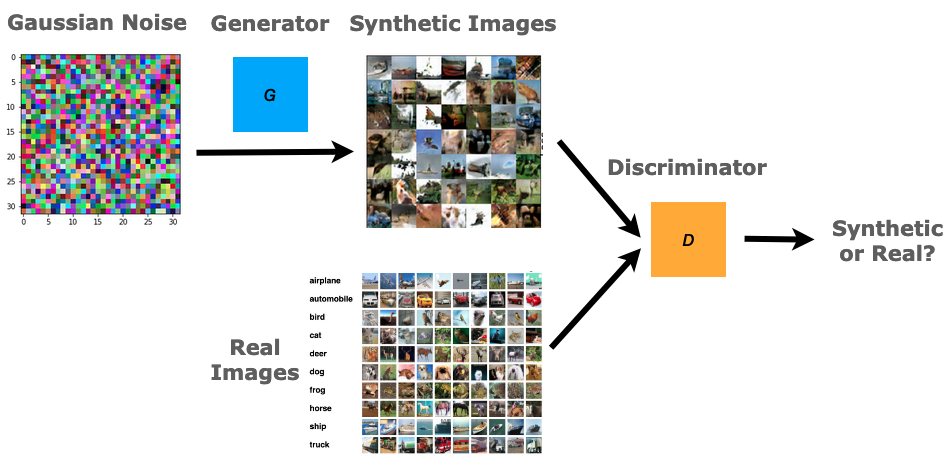

**Discriminator Objective**: 
Recall that the disciminator objective is 
$$
   \min_\varphi  \left\{ \mathbb{E}_{(x, y) \sim Q_\theta} \left[\ell(y, D_\varphi(x)) \right] \right\}
$$
where $\ell$ is the binary logistic loss and $Q_\theta$ is the mixture distribution 
of real and synthetic examples:
$$
    Q_\theta(x) = \frac{1}{2} \, \, \underbrace{P(x)}_{\text{real}} \,\, + \,\, \frac{1}{2} \,\, \underbrace{\Big([G_\theta]_\sharp R \Big)(x)}_{\text{synthetic}} \,.
$$
and the correponding labels are $1$ if the data is real and $0$ if the data is synthetic.

**Generator Objective**: 
Recall that the generator objective is 
$$
    \min_\theta \left\{ \mathbb{E}_{x' \sim [G_\theta]_\sharp R} \left[ \ell(1, D_\varphi(x')) \right] \right\}
$$
which promotes the generator to get the discriminator to predict $D_\varphi(x') \approx 1$ for synthetic $x'$.

In [7]:
import torch
import torchvision
import numpy as np

import time

import matplotlib.pyplot as plt
%matplotlib inline

import warnings

# Data

We will use some two dimensional synthetic data that follow a non-linear structure.

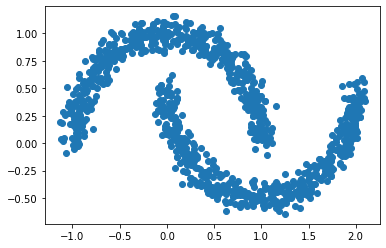

In [8]:
from sklearn.datasets import make_moons

n_samples = 1024
data, labels = make_moons(n_samples, noise=0.07) 

original_data = data

plt.scatter(data[:, 0], data[:, 1])


In [9]:
batch_size = 16

# Dataset object
dataset = torch.utils.data.TensorDataset(torch.from_numpy(data).float(), torch.from_numpy(labels).float())

# Dataloader object
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size,
    shuffle=True, num_workers=0)

In [10]:
# access dataset items
x, y = dataset[954]
print(x.shape, y)

# Use dataloader in a loop
for x, y in dataloader:
    print(x.shape, y.shape)
    break

torch.Size([2]) tensor(0.)
torch.Size([16, 2]) torch.Size([16])


# Model 

We will build our generator and discriminator to be MLPs with 2 hidden layers with ReLU non-linearities.

**Generator**: latent_dim -> hidden_dim -> hidden_dim -> data_dim (= 2)

**Discriminator**: data_dim (= 2) -> hidden_dim -> hidden_dim -> output_dim (= 1)


In [12]:
from torch.nn.functional import relu

class GeneratorModel(torch.nn.Module): 
    # Input: (b, latent_dim)
    # Output: (b, data_dim)
    def __init__(self, latent_dim=2, hidden_dim=128):
        super().__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        
        self.conv1 = torch.nn.Linear(self.latent_dim, self.hidden_dim)
        self.conv2 = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.conv3 = torch.nn.Linear(self.hidden_dim, 2)
            
    def forward(self, x):
        out = relu(self.conv1(x))
        out = relu(self.conv2(out))
        out = relu(self.conv3(out))
        return out
    
class DiscriminatorModel(torch.nn.Module):
    # Input: (b, data_dim)
    # Output: (b,)
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        self.conv1 = torch.nn.Linear(2, self.hidden_dim)
        self.conv2 = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.conv3 = torch.nn.Linear(self.hidden_dim, 1)
            
    def forward(self, x):
        out = relu(self.conv1(x))
        out = relu(self.conv2(out))
        out = relu(self.conv3(out))
        return out
    

In [13]:
generator = GeneratorModel()
discriminator = DiscriminatorModel()

print(f"Generator parameters =", sum([v.numel() for v in generator.parameters()]))
print(f"Discriminator parameters =", sum([v.numel() for v in discriminator.parameters()]))

Generator parameters = 17154
Discriminator parameters = 17025


# Generator and Discriminator Objectives

Let us now implement the objectives we discussed previously.

In [ ]:
# Import binary classification version of `cross_entropy` function
from torch.nn.functional import binary_cross_entropy_with_logits 

def discriminator_objective(real_data, latent_z, generator, discriminator):
    # real_data: (b, 2) ; latent_z: (b, 2)
    # generator/discriminator: PyTorch Modules
    # TODO: your code here
    
    fake_data = generator(latent_z)
    
    fake_preds = discriminator(fake_data)
    real_preds = discriminator(real_data)
    
    fake_loss = binary_cross_entropy_with_logits(fake_preds, zeros)
    real_loss = binary_cross_entropy_with_logits(real_preds, ones)
    
    return ((fake_loss + real_loss) / 2)
    
def generator_objective(latent_z, generator, discriminator):
    # TODO: your code here

## Logging

We track a notion of difference between the data distribution and model distribution, known as MAUVE. We will discuss these further in the lab. 

Install the package with `pip install mauve-text`.

**References**:

_MAUVE: Measuring the Gap Between Neural Text and Human Text using Divergence Frontiers._  
Krishna Pillutla, Swabha Swayamdipta, Rowan Zellers, John Thickstun, Sean Welleck, Yejin Choi, Zaid Harchaoui.  
NeurIPS 2021


_Divergence Frontiers for Generative Models: Sample Complexity, Quantization Level, and Frontier Integral._  
Lang Liu, Krishna Pillutla, Sean Welleck, Sewoong Oh, Yejin Choi, Zaid Harchaoui.  
NeurIPS 2021.

In [ ]:
import mauve

@torch.no_grad()
def logging(generator, disciminator, dataloader, num_data=1024):
    device = next(generator.parameters()).device
    n = num_data // dataloader.batch_size
    real_data = []
    for i, (x, _) in enumerate(dataloader): 
        if i == n: # got enough real data
            break
        real_data.append(x)
    real_data = torch.cat(real_data, dim=0).to(device)

    latent_z = torch.normal(0, 1, size=(num_data, generator.latent_dim), device=device) # sample from R
    syn_data = generator(latent_z)

    # Featurize: use raw data
    real_feats = real_data
    syn_feats = syn_data
    real_score = discriminator(real_data)
    syn_score = discriminator(syn_data)

    # Compute gap using mauve
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gap = mauve.compute_mauve(
            p_features=real_feats.detach().cpu(), q_features=syn_feats.detach().cpu()
        ).frontier_integral
    
    # Compute accuracy of discriminator
    accuracy_of_discriminator = # TODO: your code here
    return gap, accuracy_of_discriminator
    

In [ ]:
def minibatch_sgd_onepass(generator, discriminator, dataloader, gen_optimizer, disc_optimizer):
    device = next(generator.parameters()).device  # device on which generator is stored (CPU/GPU)
    losses_gen = []
    losses_disc = []
    for real_data, _ in dataloader:
        batch_size = real_data.shape[0]
        latent_z = torch.normal(0, 1, size=(batch_size, latent_dim), device=device)  # sample from R
        real_data = real_data.to(device) # Move data to same device as models
        
        # Discriminator update
        discriminator.zero_grad()  # Zero out gradients from last update
        loss_disc = discriminator_objective(real_data, latent_z, generator, discriminator)
        loss_disc.backward()  # similar to torch.autograd.grad, but saved in w.grad for w in model.parameters()
        disc_optimizer.step()  # Perform SGD-like udpate
        losses_disc.append(loss_disc.item())  # for logging
        
        # Generator update
        generator.zero_grad()  # Zero out gradients from last update
        loss_gen = generator_objective(latent_z, generator, discriminator)
        loss_gen.backward()  # similar to torch.autograd.grad, but saved in w.grad for w in model.parameters()
        gen_optimizer.step()  # Perform SGD-like udpate
        losses_gen.append(loss_gen.item())  # for logging
    
    return np.mean(losses_disc), np.mean(losses_gen)

## Train
Now we train the GAN.

In [ ]:
device = torch.device('cpu')  # Use CPU device

latent_dim, lr, num_epochs = 2, 0.005, 10  # Default params

# Setup models and move to device
generator = GeneratorModel(latent_dim).to(device)
discriminator = DiscriminatorModel().to(device)

# Setup optimizers
trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
disc_optimizer = torch.optim.Adam(discriminator.parameters(), **trainer_hp)
gen_optimizer = torch.optim.Adam(generator.parameters(), **trainer_hp)


gap, acc = logging(generator, discriminator, dataloader)

logs = [(0.693, 0.693, gap, acc)]

# Train!
for epoch in range(num_epochs): 
    t1 = time.time()
    loss_disc, loss_gen = minibatch_sgd_onepass(
        generator, discriminator, dataloader, gen_optimizer, disc_optimizer
    )
    t2 = time.time()
    gap, acc = logging(generator, discriminator, dataloader)
    t3 = time.time()
    logs.append((loss_disc, loss_gen, gap, acc))
    print(f"Epoch: {epoch+1}\tLoss_D: {loss_disc:.2f}\tLoss_G: {loss_gen:.2f}\tGap: {gap:.3f}\tAcc: {acc*100:.2f}",
         f"\tTime Train: {t2-t1:.2f}\t Time Log: {t3-t2:.2f}")
    

In [ ]:
logs2 = np.asarray(logs)

f, ax = plt.subplots(1, 4, figsize=(20, 4))

titles = ["Discriminator Loss", "Generator Loss", "Gap (MAUVE)", "Discriminator Accuracy"]
for i in range(4):
    ax[i].plot(logs2[:,i], lw=3)
    ax[i].set_xlabel('Epoch', fontsize=18)
    ax[i].set_title(titles[i], fontsize=18)
    

# Inspect Samples

In [ ]:
@torch.no_grad()
def sample_data(generator, n=100):
    latent_dim = generator.latent_dim
    device = next(generator.parameters()).device
    # Generated `n` samples
    latent_z = # TODO: your code here
    syn_data = # TODO: your code here  # (n, 2)
    
    plt.scatter(original_data[:, 0], original_data[:, 1], alpha=0.2, label="Original")
    plt.scatter(syn_data[:, 0], syn_data[:, 1], marker='*', s=100, label="Synthetic")
    plt.legend(fontsize=18, bbox_to_anchor=(1.04,0.5), loc="center left",)

In [ ]:
sample_data(generator)

# Interpolating Between Data

In [ ]:
@torch.no_grad()
def interpolate_data(generator, n=20):
    latent_dim = generator.latent_dim
    device = next(generator.parameters()).device  
    plt.scatter(original_data[:, 0], original_data[:, 1], alpha=0.2, label="Original")
    
    markers = ["v", "^", "<", ">", "*"]

    for i in range(5):
        z1 = torch.normal(0, 1, size=(latent_dim,), device=device)
        z2 = torch.normal(0, 1, size=(latent_dim,), device=device)
        interpolations = torch.stack([z1 + t * (z2 - z1) for t in np.linspace(0, 1, n)])
        syn_data = generator(interpolations).detach().cpu().numpy()  # (N, 2)
        plt.plot(syn_data[:, 0], syn_data[:, 1], marker=markers[i], linestyle='dotted', color=f"C{i+1}",  label=f"Synthetic {i+1}")
    
    plt.legend(fontsize=18, bbox_to_anchor=(1.04,0.5), loc="center left")

    
   

In [ ]:
interpolate_data(generator)

# Bonus Exercise 1
Train a GAN with either the S curve or Swiss roll datasets (see below). 

**Architecture**: 
Your job is to also determine a good architecture such that the synthetic samples look visually similar to the real data. 
- Throughout, use generators and discriminators that are mirror images of each other. 
- Start with a linear model each for generators and discriminator. If this does not work, add a hidden layer to get a MLP with a single hidden layer of fixed width 128. If that does not work, add a second hidden layer, and so on. 
- You may stop once you find that the model passes the eye test 2 out of 3 times. That is, from a visual inspection, it captures the real data distribution. 

**Optimization**: 
Use the optimizer settings above for the learning rate, etc. It is up to you to figure out how many epochs the model takes to converge. 

In [ ]:
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = 2048
data, labels = make_swiss_roll(n_samples, noise=0.1) 

print(data.shape)

original_data = data

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2])

In [ ]:
from sklearn.datasets import make_s_curve
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = 1024
data, labels = make_s_curve(n_samples, noise=0.1) 

print(data.shape)

original_data = data

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2])